### Introduction

By the year 2912, interstellar voyages have become a commonplace component of human civilization, presenting unique challenges and opportunities for the field of advanced data science. It was against this backdrop that a critical situation emerged involving the Spaceship Titanic, a pioneering interstellar passenger vessel. Launched just a month prior, this vessel was transporting approximately 13,000 individuals to start anew on one of three terraformed exoplanets within the neighboring stellar systems.

Unfortunately, the journey was marred by a catastrophic event as the vessel neared Alpha Centauri, heading towards the temperate exoplanet 55 Cancri E. The Spaceship Titanic encountered an undetected spacetime anomaly hidden within an interstellar dust cloud. Echoing the tragic fate of its namesake from a millennium ago, the vessel remained structurally intact, yet a significant portion of its passengers were instantaneously transported to an alternate dimension [1].

### The Challenge

To analyze the datasets recovered from the ship's compromised data systems to ascertain which passengers were affected by the anomaly and thus displaced from their original dimension. The successful identification of these individuals is imperative for the coordination of a rescue operation and holds the potential to prevent a disaster of historical magnitude.
The goal is to unlock the solution to this cosmic enigma, offering relief and hope to the myriad lives in anticipation of news regarding their displaced kin.


#### Reference
https://www.kaggle.com/competitions/spaceship-titanic/overview

In [9]:
# Begin by importing all required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets


# Define plot settings
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.figsize"] = (20,10)

### Dataset explanation

- **`PassengerId`**: A unique Id for each passenger, formatted as ***gggg_pp*** where ***gggg*** indicates a group the passenger is traveling with, and ***pp*** is their number within the group. People in a group are often family members, but not always.

- **`HomePlanet`**: The planet the passenger departed from, typically their planet of permanent residence.

- **`CryoSleep`**: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- **`Cabin`**: The cabin number where the passenger is staying, formatted as ***deck/num/side***, where ***side*** can be either ***P*** for Port or ***S*** for Starboard.

- **`Destination`**: The planet the passenger will be debarking to.

- **`Age`**: The age of the passenger.

- **`VIP`**: Whether the passenger has paid for special VIP service during the voyage.

- **`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`**: The amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- **`Name`**: The first and last names of the passenger.

- **`Transported`**: Whether the passenger was transported to another dimension. This is the target column for prediction.


## 1. Data Analysis
### First, identify missing values in the data

In [8]:
# Read data
train_df = pd.read_csv('csv_files/train.csv')

# Preview data
print('Raw data format:')
display(train_df.head())

# Determine any missing data
print('Amount of missing data per column:')
display(train_df.isna().sum())

Raw data format:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Amount of missing data per column:


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

The dataset contains numerous missing values. Simply dropping them may reduce the power of our model . Before dropping any values, we consider imputation among other methods. To do this, we must first engage in exploratory data analysis.

### 1.1 Target Variable Analysis 

/var/folders/dm/vyyc77zn4q53knv4g379r89h0000gn/T/ipykernel_35813/1245284505.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


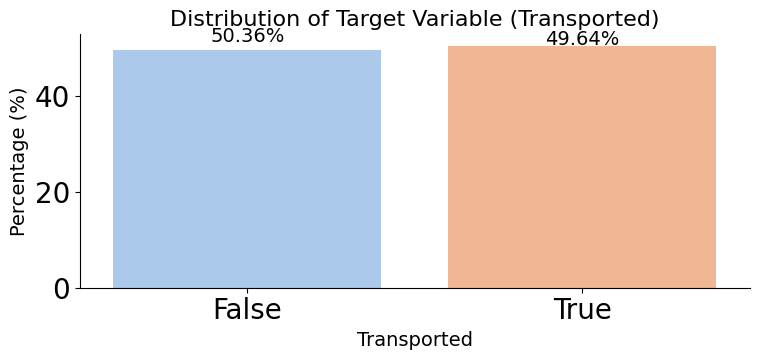

In [10]:
import seaborn as sns

# Calculate the proportion of each class in the target variable 'Transported'
class_counts = train_df['Transported'].value_counts(normalize=True) * 100

# Set the color palette
colors = sns.color_palette('pastel')[0:len(class_counts)]

# Plot the distribution of the target variable
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.title('Distribution of Target Variable (Transported)', fontsize=16)
plt.xlabel('Transported', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)

# Annotate proportions on the bars
for index, value in enumerate(class_counts):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', fontsize=14)

sns.despine()
plt.tight_layout()
plt.show()


**Inference:**
> The distribution of the target variable is approximately equal, showing that about half of the people on the ship were mysteriously transported. This shows us that the data is indeed balanced, so accuracy is a good metric.

## 1.2 Visualisation of Coontinous Features 
Having an idea of the distribution of the continous features in the dataframe will give us an idea of the skew present in the data.

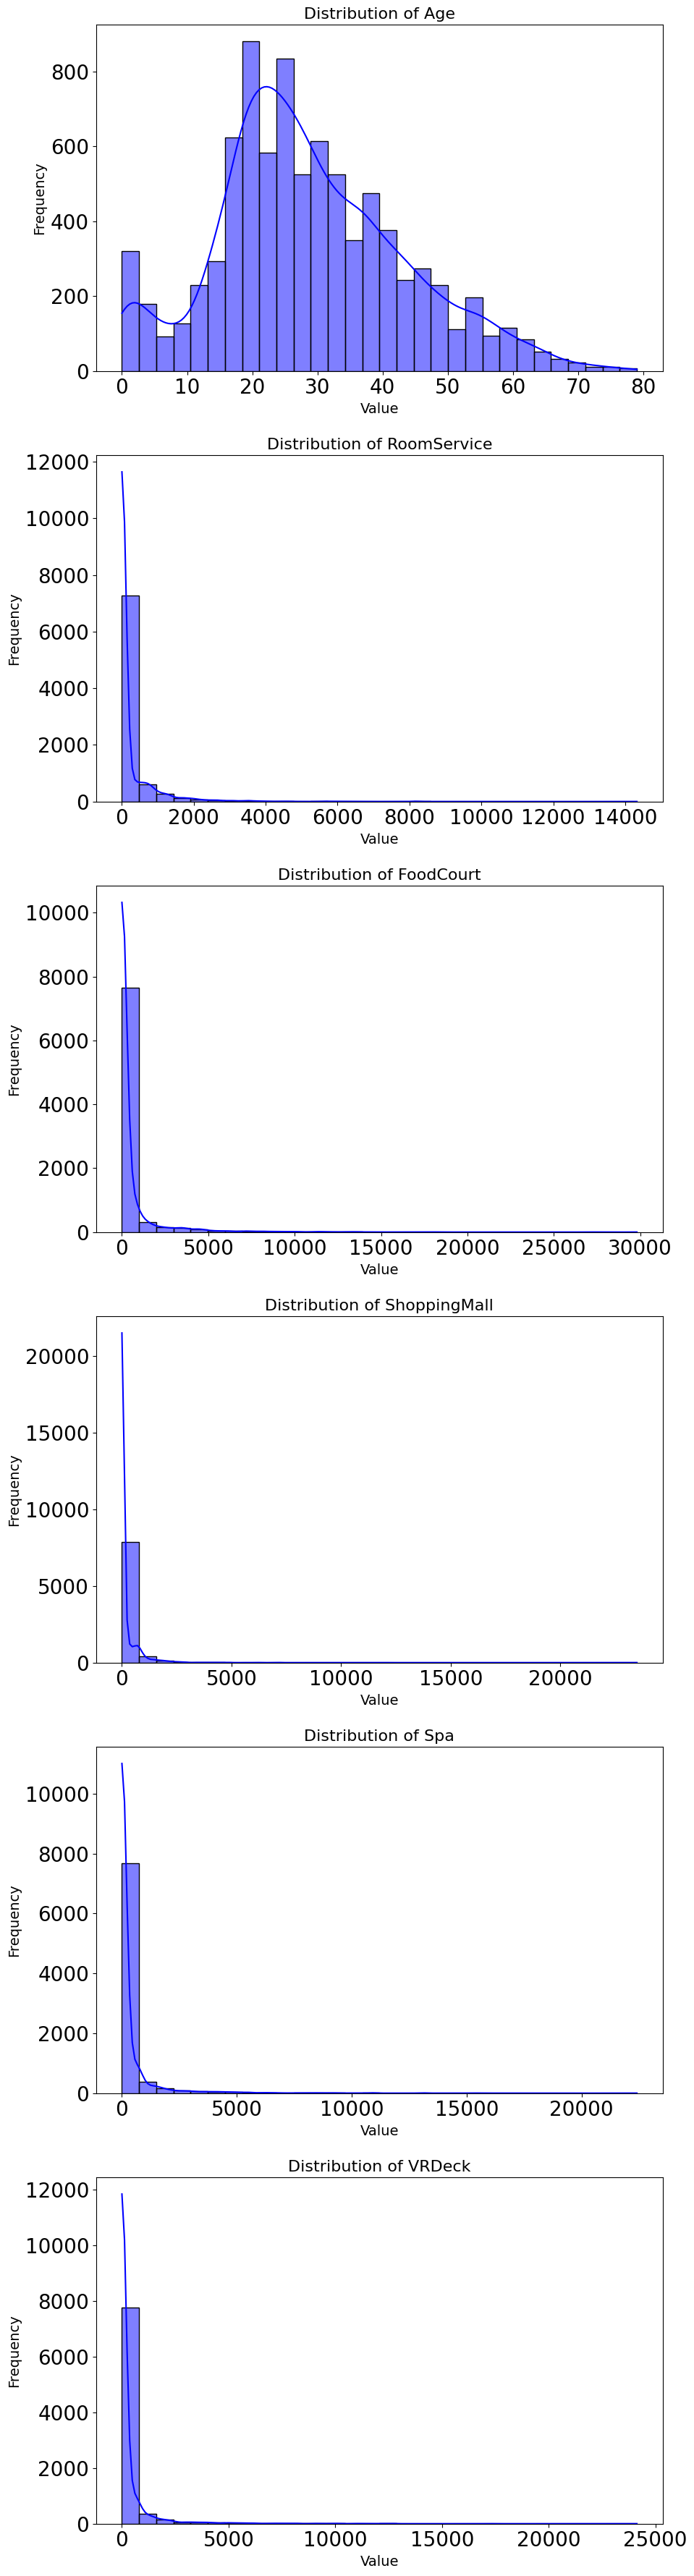

In [11]:
# Identify continuous columns
cont_cols = [f for f in train_df.columns if train_df[f].dtype in [np.float64, np.int64] and train_df[f].nunique() > 20]

# Create subplots for each continuous column
fig, axs = plt.subplots(len(cont_cols), 1, figsize=(10, 6 * len(cont_cols)))

if len(cont_cols) == 1: # Ensure axs is iterable
    axs = [axs]

for i, col in enumerate(cont_cols):
    sns.histplot(train_df[col], ax=axs[i], kde=True, color='blue', bins=30)
    axs[i].set_title(f'Distribution of {col}', fontsize=16)
    axs[i].set_xlabel('Value', fontsize=14)
    axs[i].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


>From the above distributions we see that all the features are heavily skewed to the left, with only the age being slighly less skewed, with most of the people on board in the age range of 20-30 years old.

/var/folders/dm/vyyc77zn4q53knv4g379r89h0000gn/T/ipykernel_35813/814789467.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i], palette='pastel')
/var/folders/dm/vyyc77zn4q53knv4g379r89h0000gn/T/ipykernel_35813/814789467.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i], palette='pastel')
/var/folders/dm/vyyc77zn4q53knv4g379r89h0000gn/T/ipykernel_35813/814789467.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Transported', y=col, data=t

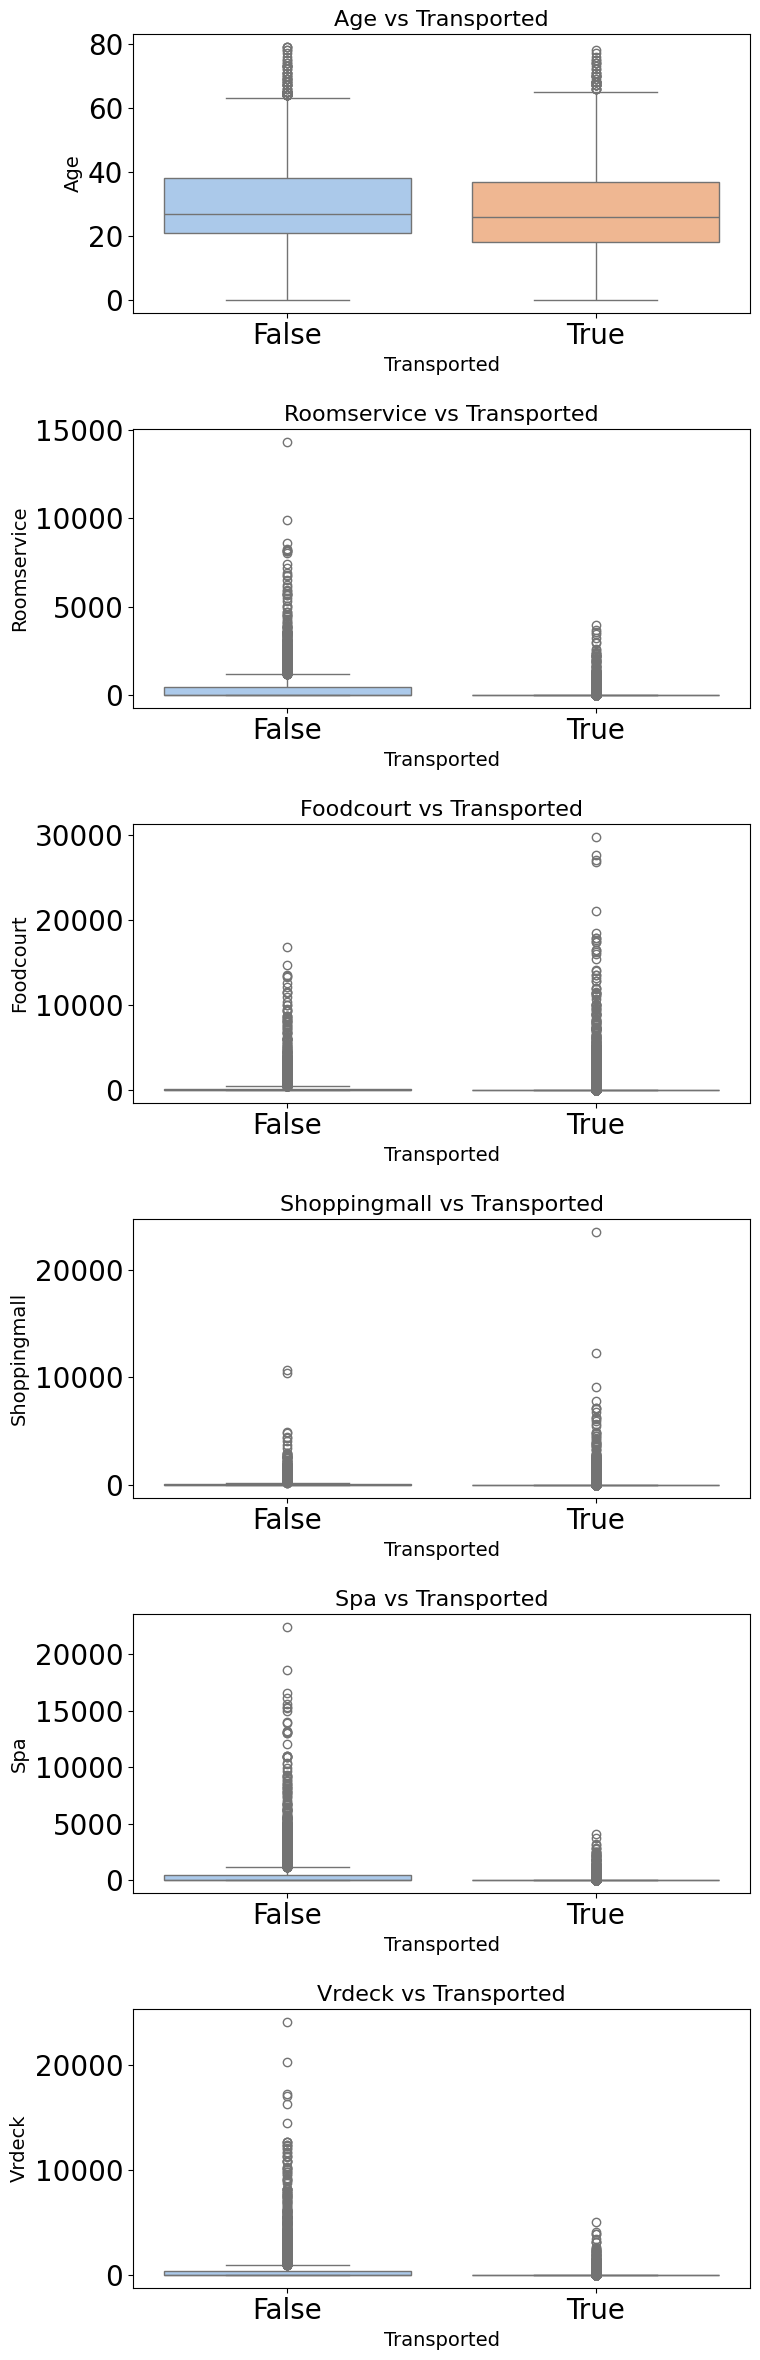

In [12]:
# Create subplots for each continuous feature vs Target
fig, axs = plt.subplots(nrows=len(cont_cols), figsize=(8, 4 * len(cont_cols)))

if len(cont_cols) == 1: # Ensure axs is iterable
    axs = [axs]

for i, col in enumerate(cont_cols):
    sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i], palette='pastel')
    axs[i].set_title(f'{col.title()} vs Transported', fontsize=16)
    axs[i].set_xlabel('Transported', fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)

plt.tight_layout()
plt.show()


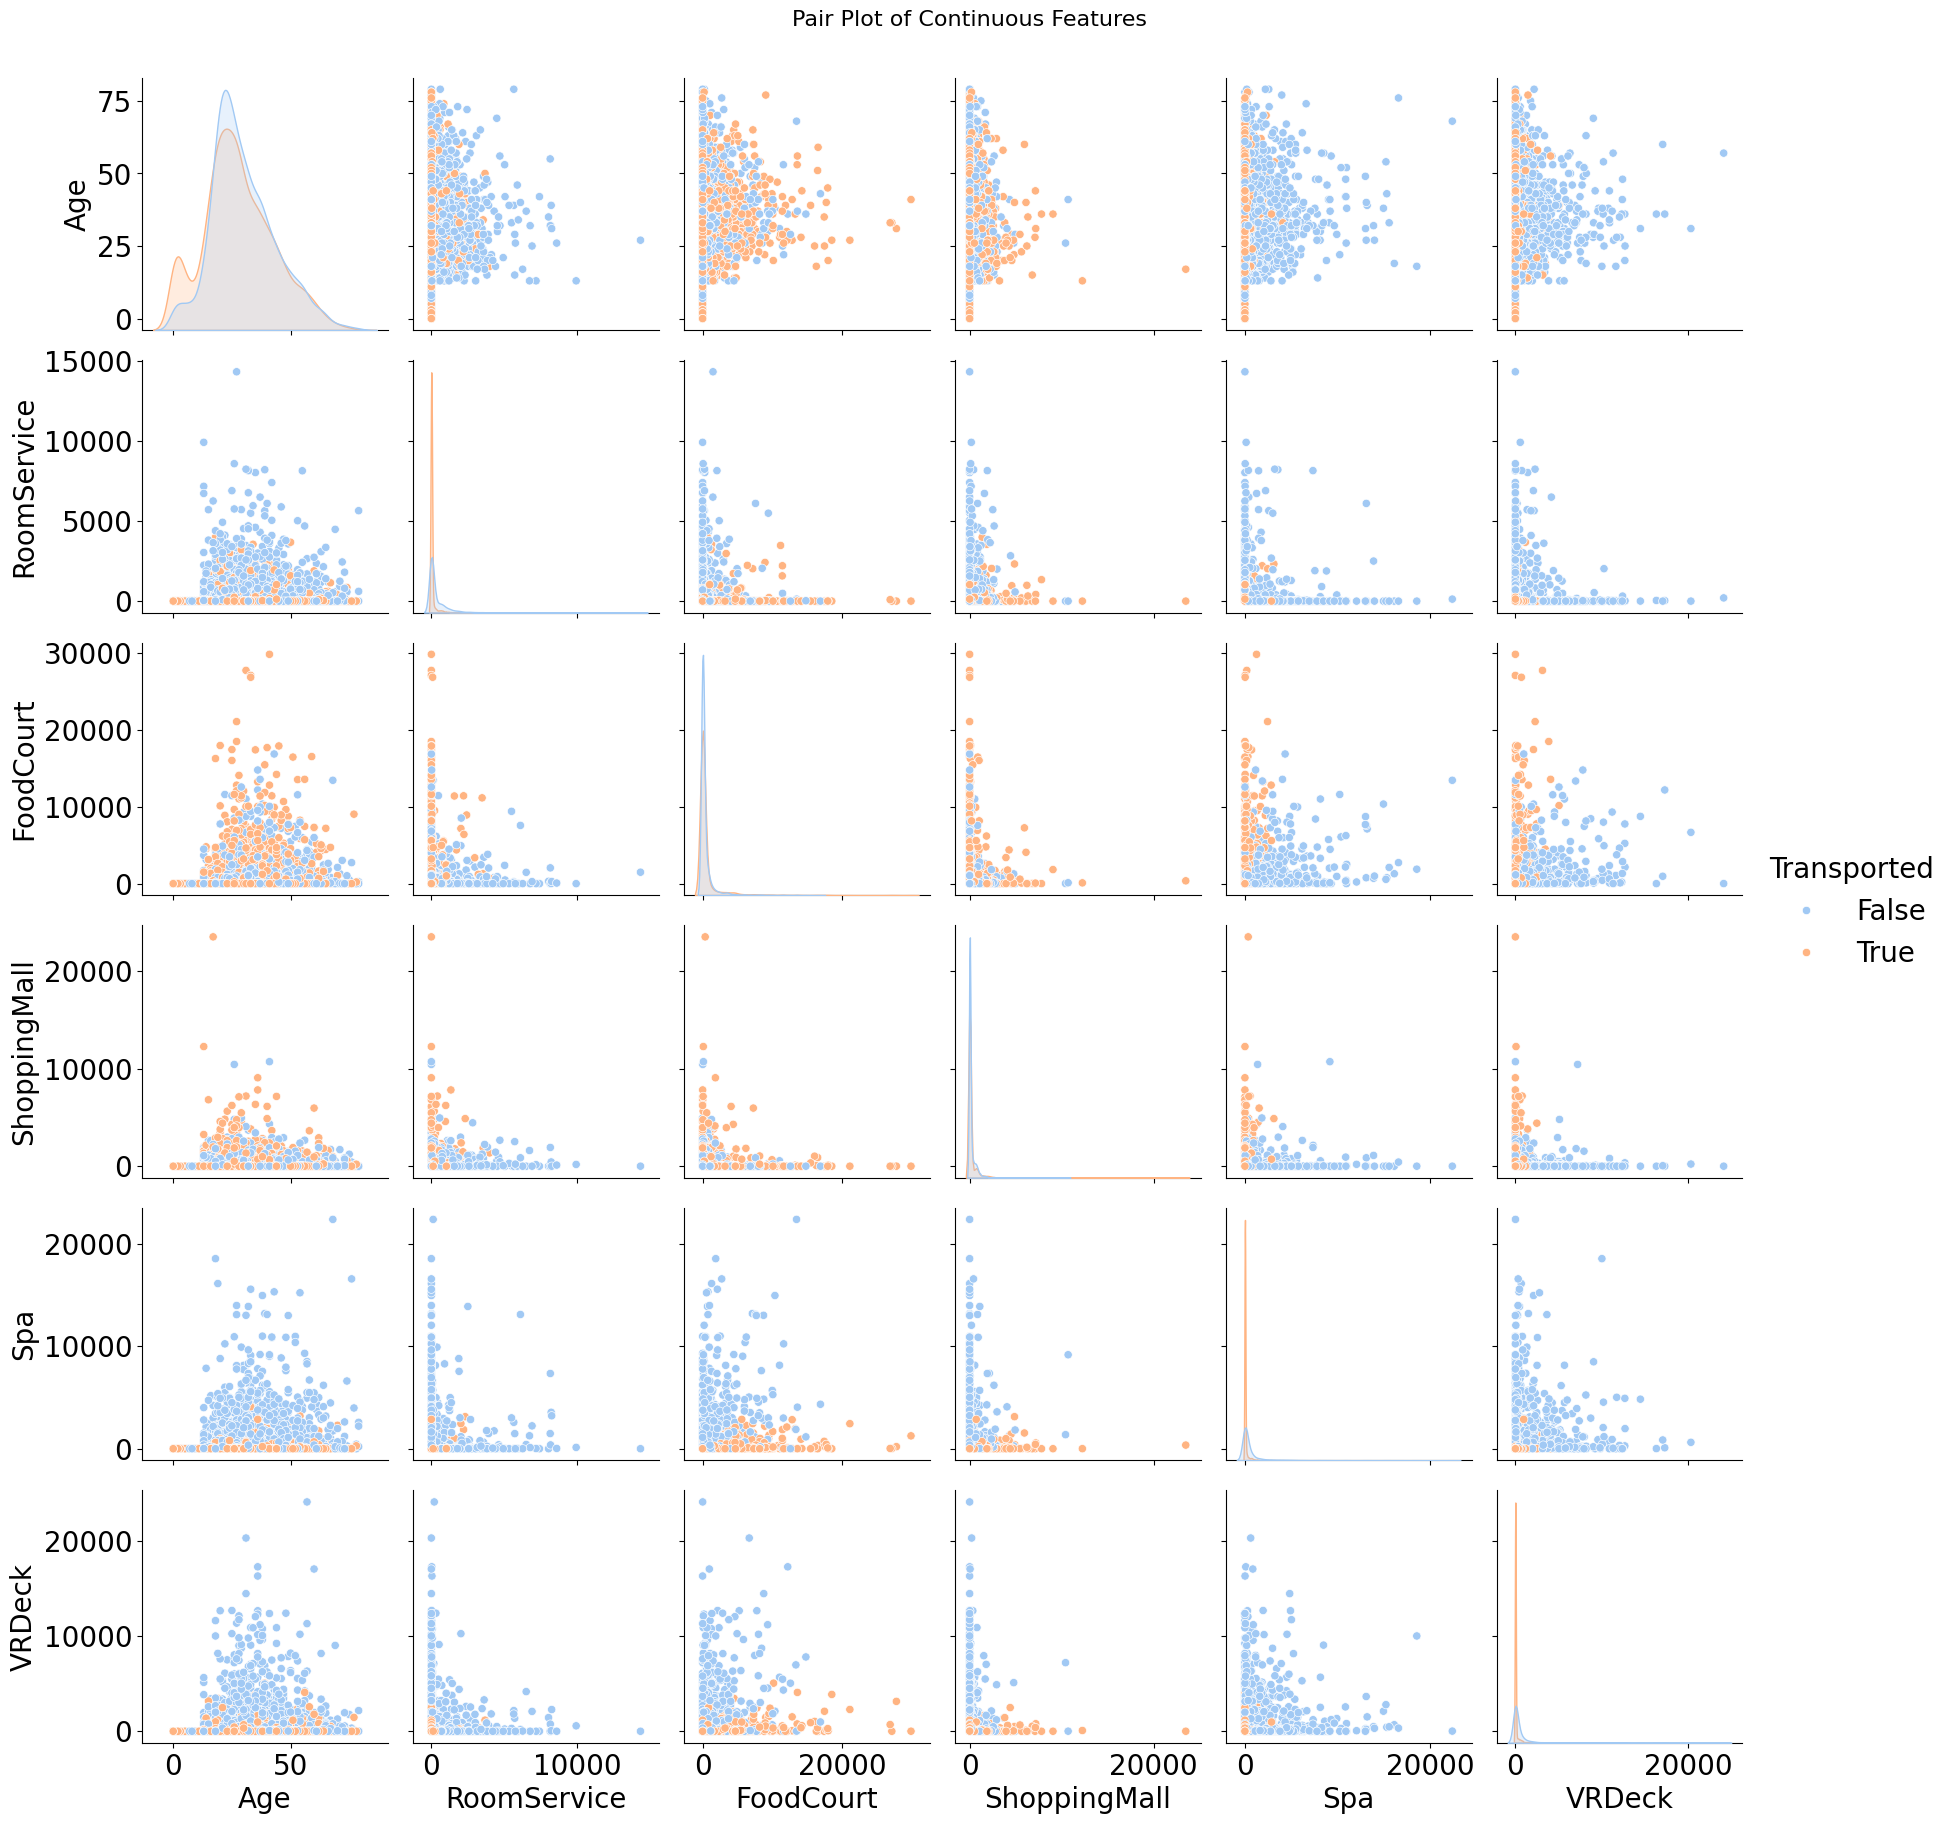

In [13]:
sns.pairplot(data=train_df, vars=cont_cols, hue='Transported', palette='pastel', height=3)
plt.suptitle('Pair Plot of Continuous Features', size=16, y=1.02)
plt.show()
